In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 20c: 

## LSTM - Weather data


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

2023-12-05 11:15:20.931052: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 11:15:20.980197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 11:15:20.980226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 11:15:20.981388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 11:15:20.988929: I tensorflow/core/platform/cpu_feature_guar

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# Strictly for tensorflow version 2.12
### To hide bugs throwing warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# Some basic parameters

inpDir = '../DNN/DNN_Sep2023/input/' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 50  # number of cycles to run

ALPHA = 0.001  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 32

PATIENCE = 10

LR_PATIENCE = 2

FACTOR_LR = 0.5

IMG_HEIGHT = 190

IMG_WIDTH = 190

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [6]:
def fn_plot_label(tr_ds , ts_ds):
    
    plt.figure(figsize=(15,5))                                           # Instantiate the figure
    
    plt.subplot(1,2,1)                                                   # First out of 2
    train_labels = tf.concat([lbl for img, lbl in tr_ds],axis=0).numpy() #Get the labels
    unique, _, counts = tf.unique_with_counts(train_labels)              #Get the counts
    plt.bar(range(len(unique)),counts, align='center', color='DarkBlue') #Barplot the counts
    plt.xticks(range(len(unique)),class_names)
    plt.title("Training Set")
    
    
    plt.subplot(1,2,2)
    test_labels = tf.concat([lbl for img, lbl in ts_ds],axis=0).numpy()
    unique, _, counts = tf.unique_with_counts(test_labels)
    plt.bar(range(len(unique)),counts, align='center', color='orange')
    plt.xticks(range(len(unique)),class_names)
    plt.title("Testing Set")
    

## Using the Flower Data

In [7]:
data_dir = os.path.join(inpDir,subDir)
data_dir

'../DNN/DNN_Sep2023/input/flower_photos'

In [8]:
os.listdir(data_dir)

['sunflowers', 'LICENSE.txt', 'tulips', 'dandelion', 'roses', 'daisy']

In [9]:
# Training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,                             # Path of the data directory
    validation_split=TEST_SIZE,           # What ratio of validation data
    subset='training',                    # Purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT,IMG_WIDTH],    # images of all sizes will be squezzed to given size  
    batch_size=BATCH_SIZE
)

# Test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,                             # Path of the data directory
    validation_split=TEST_SIZE,           # What ratio of validation data
    subset='validation',                  # Purpose
    seed=RANDOM_STATE,
    image_size=[IMG_HEIGHT,IMG_WIDTH],    # images of all sizes will be squezzed to given size 
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
# It is picking up the class names
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

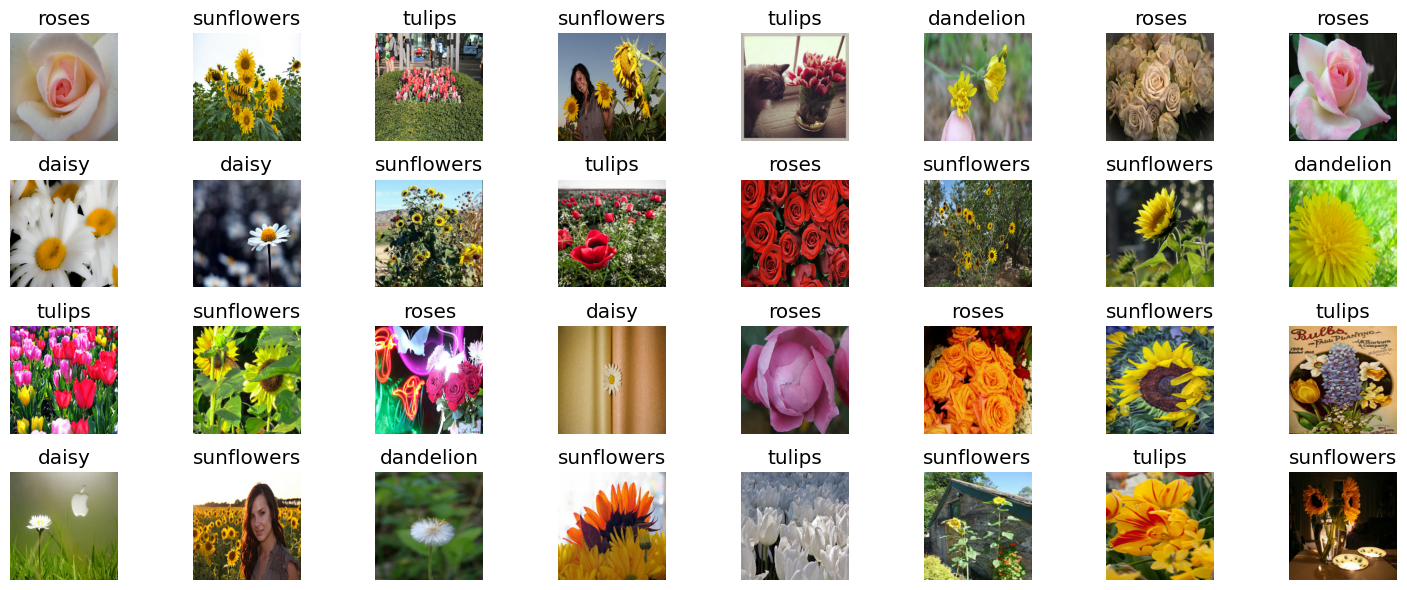

In [11]:
# Plotting for train data
plt.figure(figsize=(15,6))

for images,labels in train_ds.take(1):                 # Get me one batch
    for i in range(BATCH_SIZE):                        # Loop over batch
        plt.subplot(int(BATCH_SIZE/8),8, i+1)          # access the axis
        plt.grid(False)                                # no to grid
        plt.imshow(images[i].numpy().astype('uint8'))  #show image conver to numpy and int
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

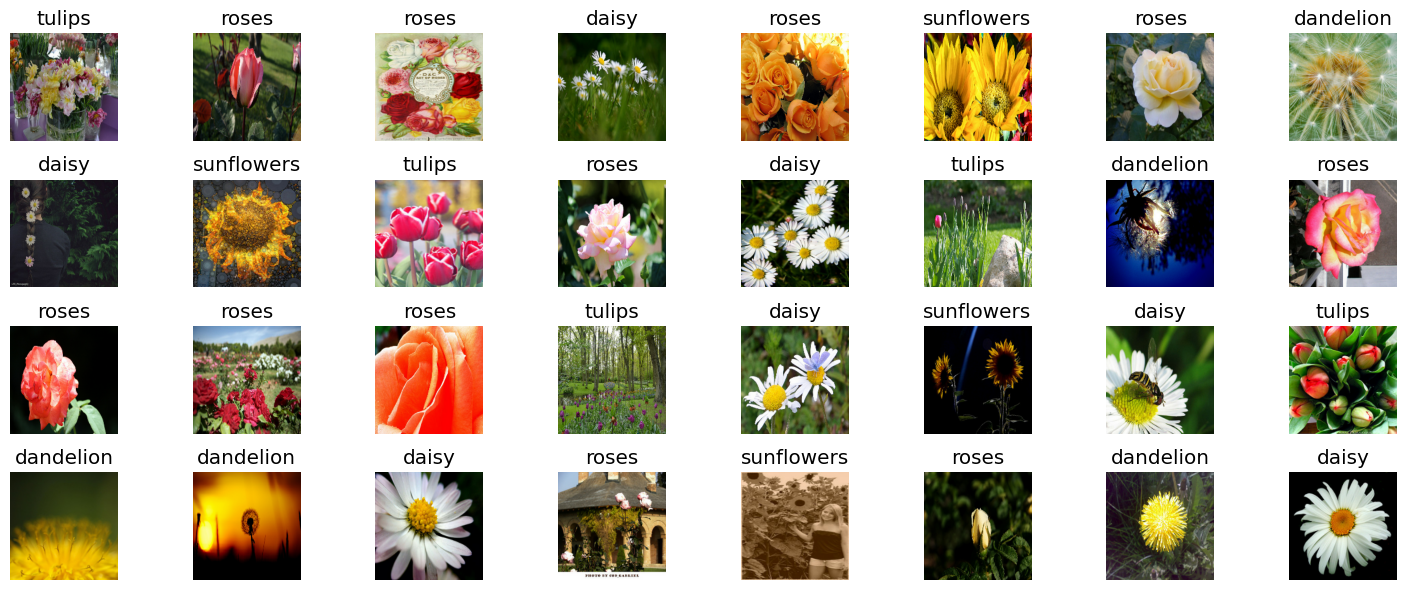

In [12]:
# Plotting for test data
plt.figure(figsize=(15,6))

for images,labels in test_ds.take(1):                 # Get me one batch
    for i in range(BATCH_SIZE):                        # Loop over batch
        plt.subplot(int(BATCH_SIZE/8),8, i+1)          # access the axis
        plt.grid(False)                                # no to grid
        plt.imshow(images[i].numpy().astype('uint8'))  #show image conver to numpy and int
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
plt.show()

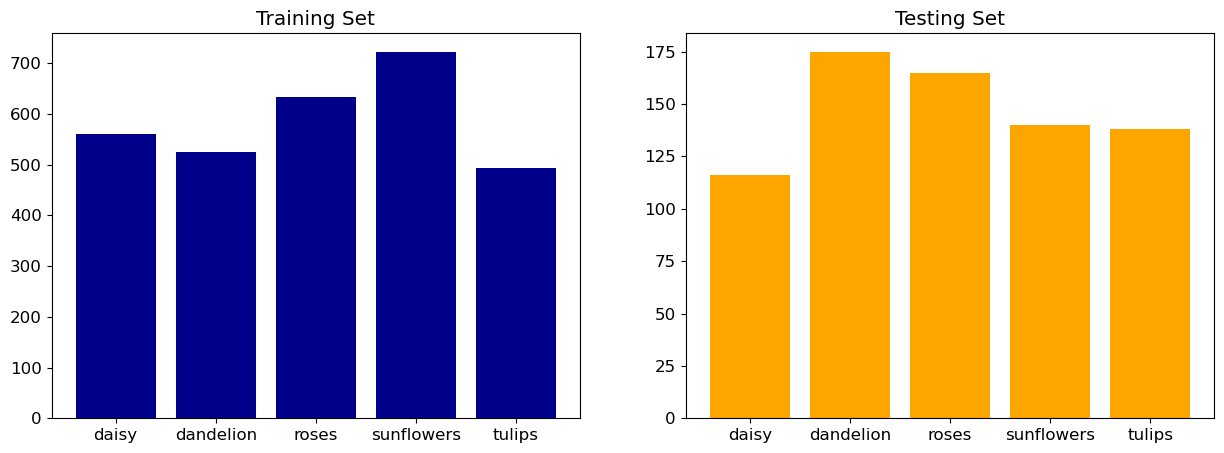

In [13]:
fn_plot_label(train_ds,test_ds)

In [14]:
input_shape = (IMG_HEIGHT,IMG_WIDTH, 3)

## Random Zoom

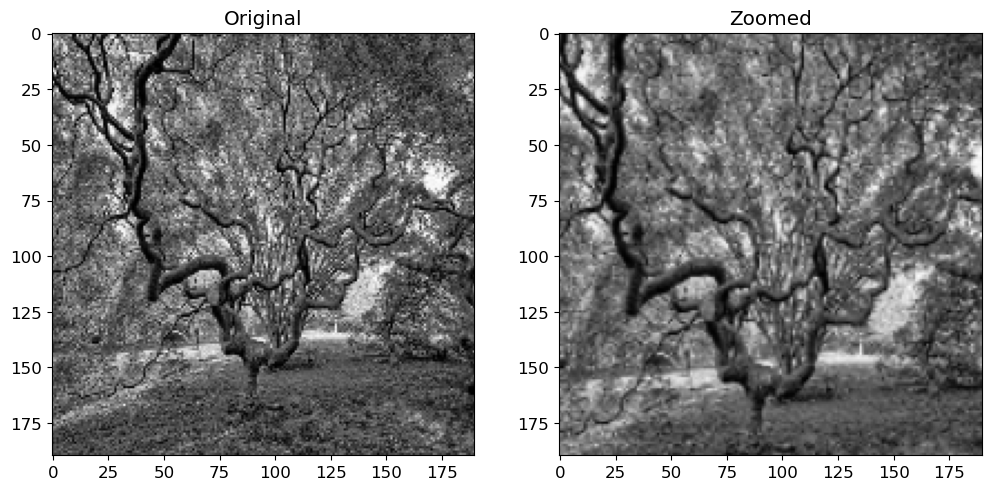

In [15]:
layer = tf.keras.layers.RandomZoom(height_factor=[-0.2,-0.2],
                                  width_factor=[-0.2,-0.2])

plt.figure()

img_num=3

for images,labels in test_ds.take(1):                 # Get me one batch
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    plt.title("Zoomed")
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

## Random Rotation

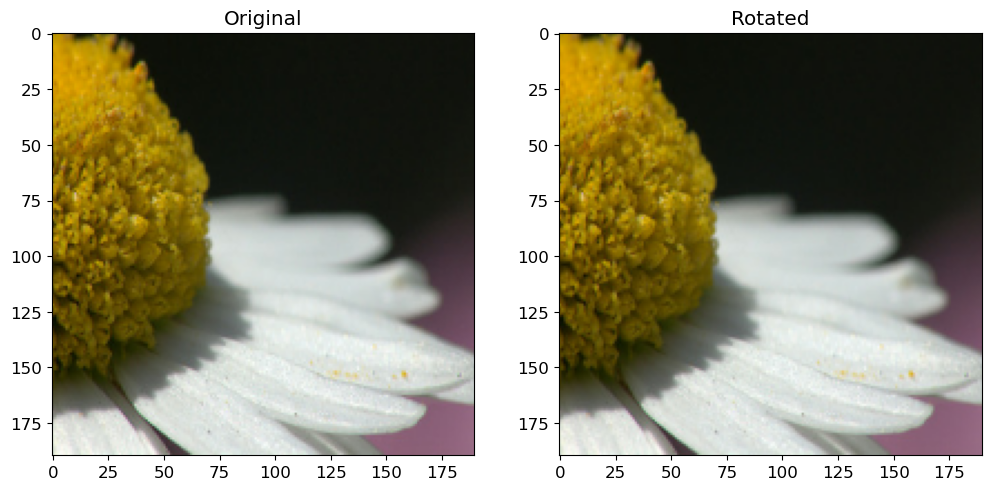

In [16]:
layer = tf.keras.layers.RandomRotation(factor=[-0.2,0.3])

plt.figure()

img_num=3

for images,labels in test_ds.take(1):                 # Get me one batch
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    plt.title("Rotated")
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Build Model

model = tf.keras.Sequential()

model.add(tf.keras.layers.Rescaling(1/255,))    # Convert between 0 - 1

# stage

model.add(tf.keras.layers.Conv2D(8,(3,3),activation='relu')) # 188 x 188 x 8 
model.add(tf.keras.layers.MaxPool2D(2,2)) # 94 x 94 x 8


# stage

model.add(tf.keras.layers.Conv2D(16,(3,3),activation='relu')) # 92 x 92 x 16 
model.add(tf.keras.layers.MaxPool2D(2,2)) # 46 x 46 x 8



# stage

model.add(tf.keras.layers.Conv2D(32,(3,3),activation='relu')) # 44 x 44 x 32 
model.add(tf.keras.layers.MaxPool2D(2,2)) # 22 x 22 x 32


# stage

model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu')) # 20 x 20 x 64 
model.add(tf.keras.layers.MaxPool2D(2,2)) # 10 x 10 x 64


# stage

model.add(tf.keras.layers.Conv2D(128,(3,3),activation='relu')) # 8 x 8 x 128 
model.add(tf.keras.layers.MaxPool2D(2,2)) # 4 x 4 x 128

model.add(tf.keras.layers.Conv2D(256,(3,3),activation='relu')) # 2 x 2 x 256 

model.add(tf.keras.layers.Flatten()) # Flatten 

model.add(tf.keras.layers.Dense(256,activation='relu')) # Dense 1 

model.add(tf.keras.layers.Dense(5))


In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optim = tf.keras.optimizers.Adam(learning_rate=ALPHA)

model.compile(loss=loss_fn,optimizer=optim,metrics=['accuracy'])

In [20]:
filepath = os.path.join(modelDir,subDir,altName)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=1,
    restore_best_weights=True,
    baseline=None
)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)

model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor= 'val_loss',
    verbose= 0,
    save_best_only= True,
    save_weights_only= True,
    mode= 'auto'
)

In [22]:
history = model.fit(train_ds,
         validation_data=test_ds,
         epochs=200,
         verbose=1,
        batch_size = BATCH_SIZE,
        callbacks=[model_callback,early_stopping,lr_decay]
        )

Epoch 1/200
92/92 [==============================] - 13s 115ms/step - loss: 1.3419 - accuracy: 0.4057 - val_loss: 1.2080 - val_accuracy: 0.4837 - lr: 0.0010
Epoch 2/200
92/92 [==============================] - 9s 96ms/step - loss: 1.1061 - accuracy: 0.5286 - val_loss: 1.0405 - val_accuracy: 0.5817 - lr: 0.0010
Epoch 3/200
92/92 [==============================] - 9s 95ms/step - loss: 0.9670 - accuracy: 0.5937 - val_loss: 1.1342 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 4/200
92/92 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.6468
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
92/92 [==============================] - 9s 95ms/step - loss: 0.8804 - accuracy: 0.6468 - val_loss: 1.0615 - val_accuracy: 0.5940 - lr: 0.0010
Epoch 5/200
92/92 [==============================] - 9s 96ms/step - loss: 0.7621 - accuracy: 0.6972 - val_loss: 0.8771 - val_accuracy: 0.6730 - lr: 5.0000e-04
Epoch 6/200
92/92 [==============================] - 9s 96ms

In [23]:
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
   
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
   
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
   
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
   
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
   
   
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
   
    plt.tight_layout()

In [24]:
plot_df = pd.DataFrame(history.history)

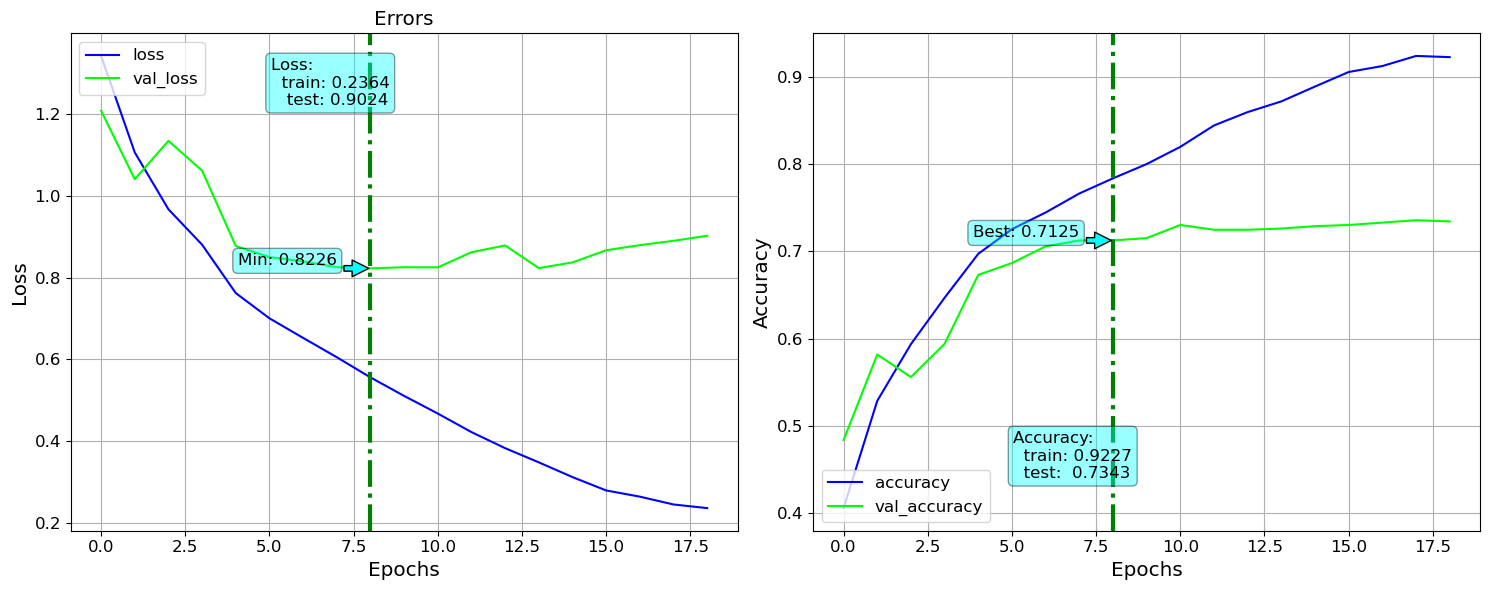

In [25]:
plot_tf_hist(plot_df)